In [1]:
import os
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
import pandas as pd

from sklearn.cluster import KMeans
from skimage.io import imshow, imread
import skimage

from aicsimageio import AICSImage
from aicspylibczi import CziFile
from sklearn.cluster import MiniBatchKMeans

In [2]:
root = r'/Users/lovely_shufan/'
#workdir = root + r'Documents/'
img_dir = root+ r'Dropbox (Edison_Lab@UGA)/AMF/AMF Imaging 2022/0_inference_using_MaskRCNN_2021/0_raw_czi/GA_MINE_2022_imaged_by_Isabella_Wilson/' 
#os.makedirs(output_dir,exist_ok=True)

In [3]:
print(os.listdir(img_dir))

['PI52606_1.czi', 'PI52606_2.czi', 'PI52606_3.czi']


In [4]:
# read in czi file
img_file = os.path.join(img_dir,'PI52606_1.czi')
aicsfile = AICSImage(img_file)

AICSImage read the mosaic image as stitched; scenes can be accessed by set_scene.


For RGB/BGR images, "S" dimension no longer represent "Scene" but "Samples" dimension (RGB / BGR) 

In [5]:
print(aicsfile.scenes)
print(aicsfile.current_scene)

('ScanRegion0', 'ScanRegion1', 'ScanRegion2', 'ScanRegion3', 'ScanRegion4', 'ScanRegion5', 'ScanRegion6', 'ScanRegion7', 'ScanRegion8', 'ScanRegion9', 'ScanRegion10', 'ScanRegion11', 'ScanRegion12', 'ScanRegion13', 'ScanRegion14', 'ScanRegion15', 'ScanRegion16', 'ScanRegion17', 'ScanRegion18', 'ScanRegion19', 'ScanRegion20', 'ScanRegion21', 'ScanRegion22', 'ScanRegion23')
ScanRegion0


In [6]:
#extract image of scene 18
aicsfile.set_scene(2)
scene = aicsfile.get_image_data("YXS", T=0,C=0,Z=0) # numpy.ndarray
print(scene.shape)

(6916, 15005, 3)


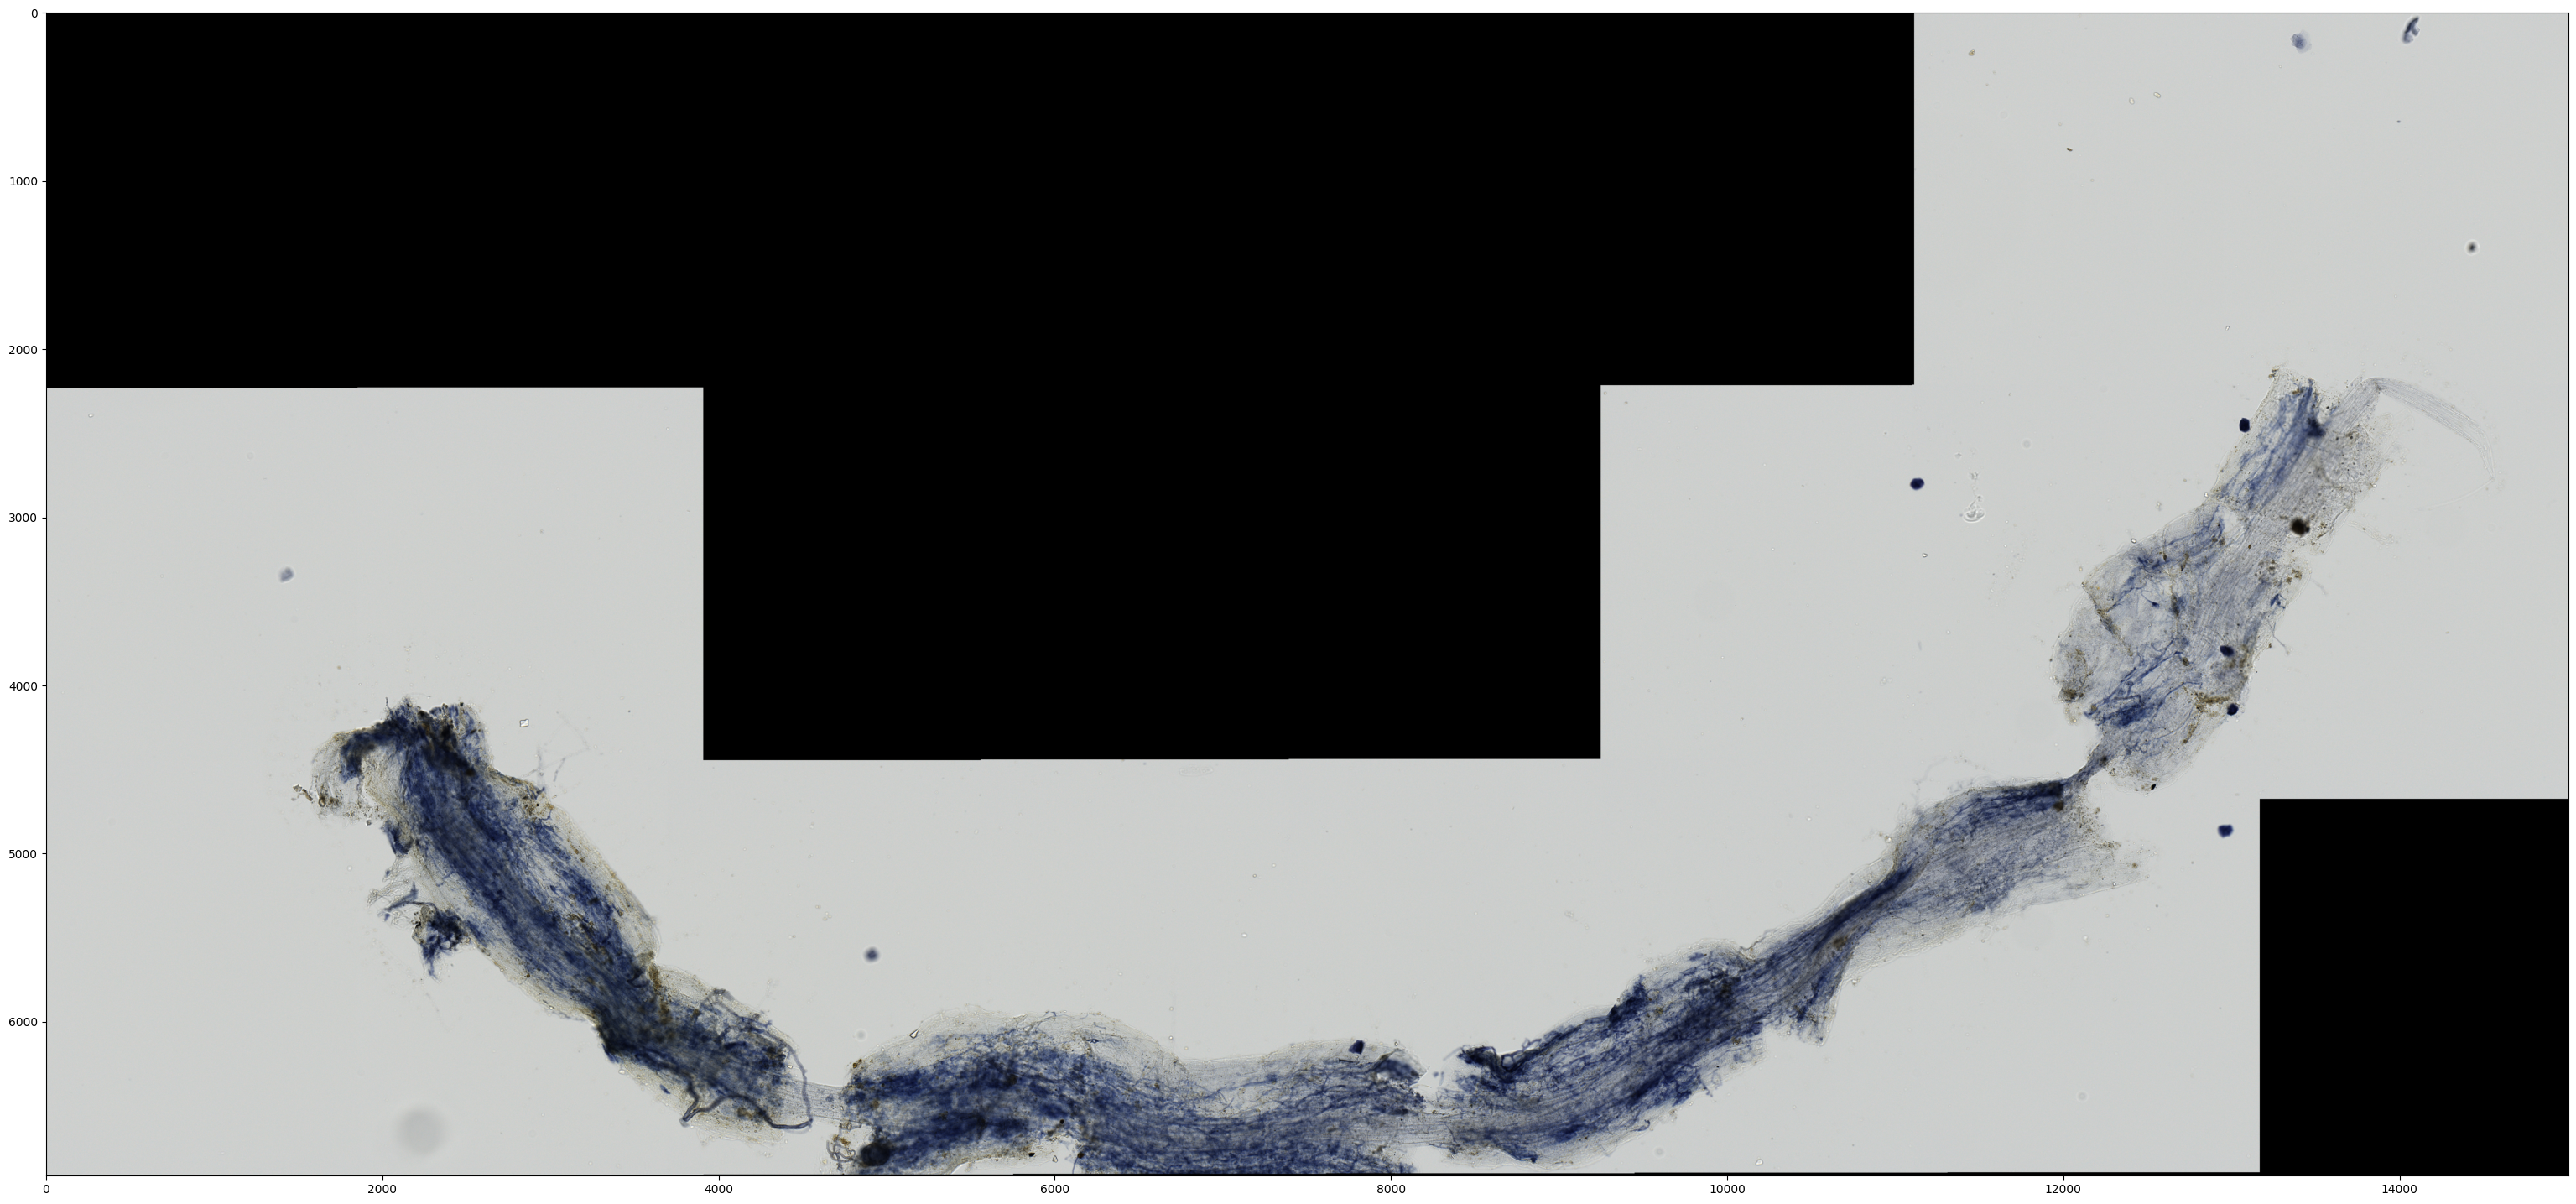

In [7]:
plt.figure(figsize = (48,18))
plt.imshow(cv2.cvtColor(scene, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
print(type(scene))
print(scene.shape)

<class 'numpy.ndarray'>
(6916, 15005, 3)


In [9]:
# Reshape the image to a 2D array of pixels and 3 color values (RGB)
pixels = scene.reshape(-1, 3)

# Convert to float32 for numerical stability
pixels = np.float32(pixels)

# Define the number of clusters
k = 4  # for example

# Create a MiniBatchKMeans instance with k clusters
minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=10)

# Fit the model to the data
minibatch_kmeans.fit(pixels)
labels = minibatch_kmeans.fit_predict(pixels)

In [10]:
# Replace each pixel value with its nearest centroid from the MiniBatchKMeans model
compressed_pixels = minibatch_kmeans.cluster_centers_[minibatch_kmeans.labels_]
compressed_image = compressed_pixels.reshape(scene.shape)

# Cast the pixels back to 8-bit integers
compressed_image = np.uint8(compressed_image)


In [11]:
# Assign random colors to each segment for better visual distinction
#colors = [tuple(np.random.randint(0, 255, 3).tolist()) for _ in range(k)]

# Get unique labels and number of unique labels
unique_labels = np.unique(labels)
n_unique_labels = len(unique_labels)

# Generate random colors from the viridis palette
viridis = plt.cm.get_cmap('viridis', n_unique_labels)
colors = viridis(np.linspace(0, 1, n_unique_labels,endpoint=False))

/var/folders/mv/p4jr8xs52gl7rk_wf4pn6mn80000gn/T/ipykernel_11593/2314929484.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', n_unique_labels)


In [13]:
# Create a blank canvas with the same height and width as the original image
segmented_image = np.zeros_like(scene)

# Assign colors from the viridis palette to each segment
for label, color in zip(unique_labels, colors):
    mask = labels == label
    segmented_image[mask.reshape(*scene.shape[:2])] = (color[:3] * 255).astype('uint8')
    
# Convert the segmented image back to uint8 if you used random colors (which are floats)
segmented_image = segmented_image.astype('uint8')


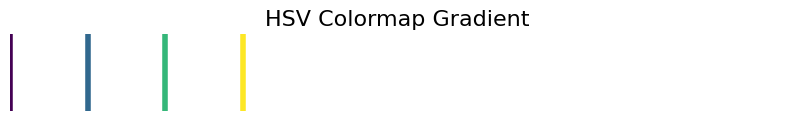

In [14]:
# Plot each color as a vertical line to visualize the gradient
plt.figure(figsize=(10, 1))
for i, color in enumerate(colors):
    plt.axvline(i, color=color, linewidth=4)

# Set the limits and labels of the plot for better visualization
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.axis('off')
plt.title('HSV Colormap Gradient', fontsize=16)
plt.show()

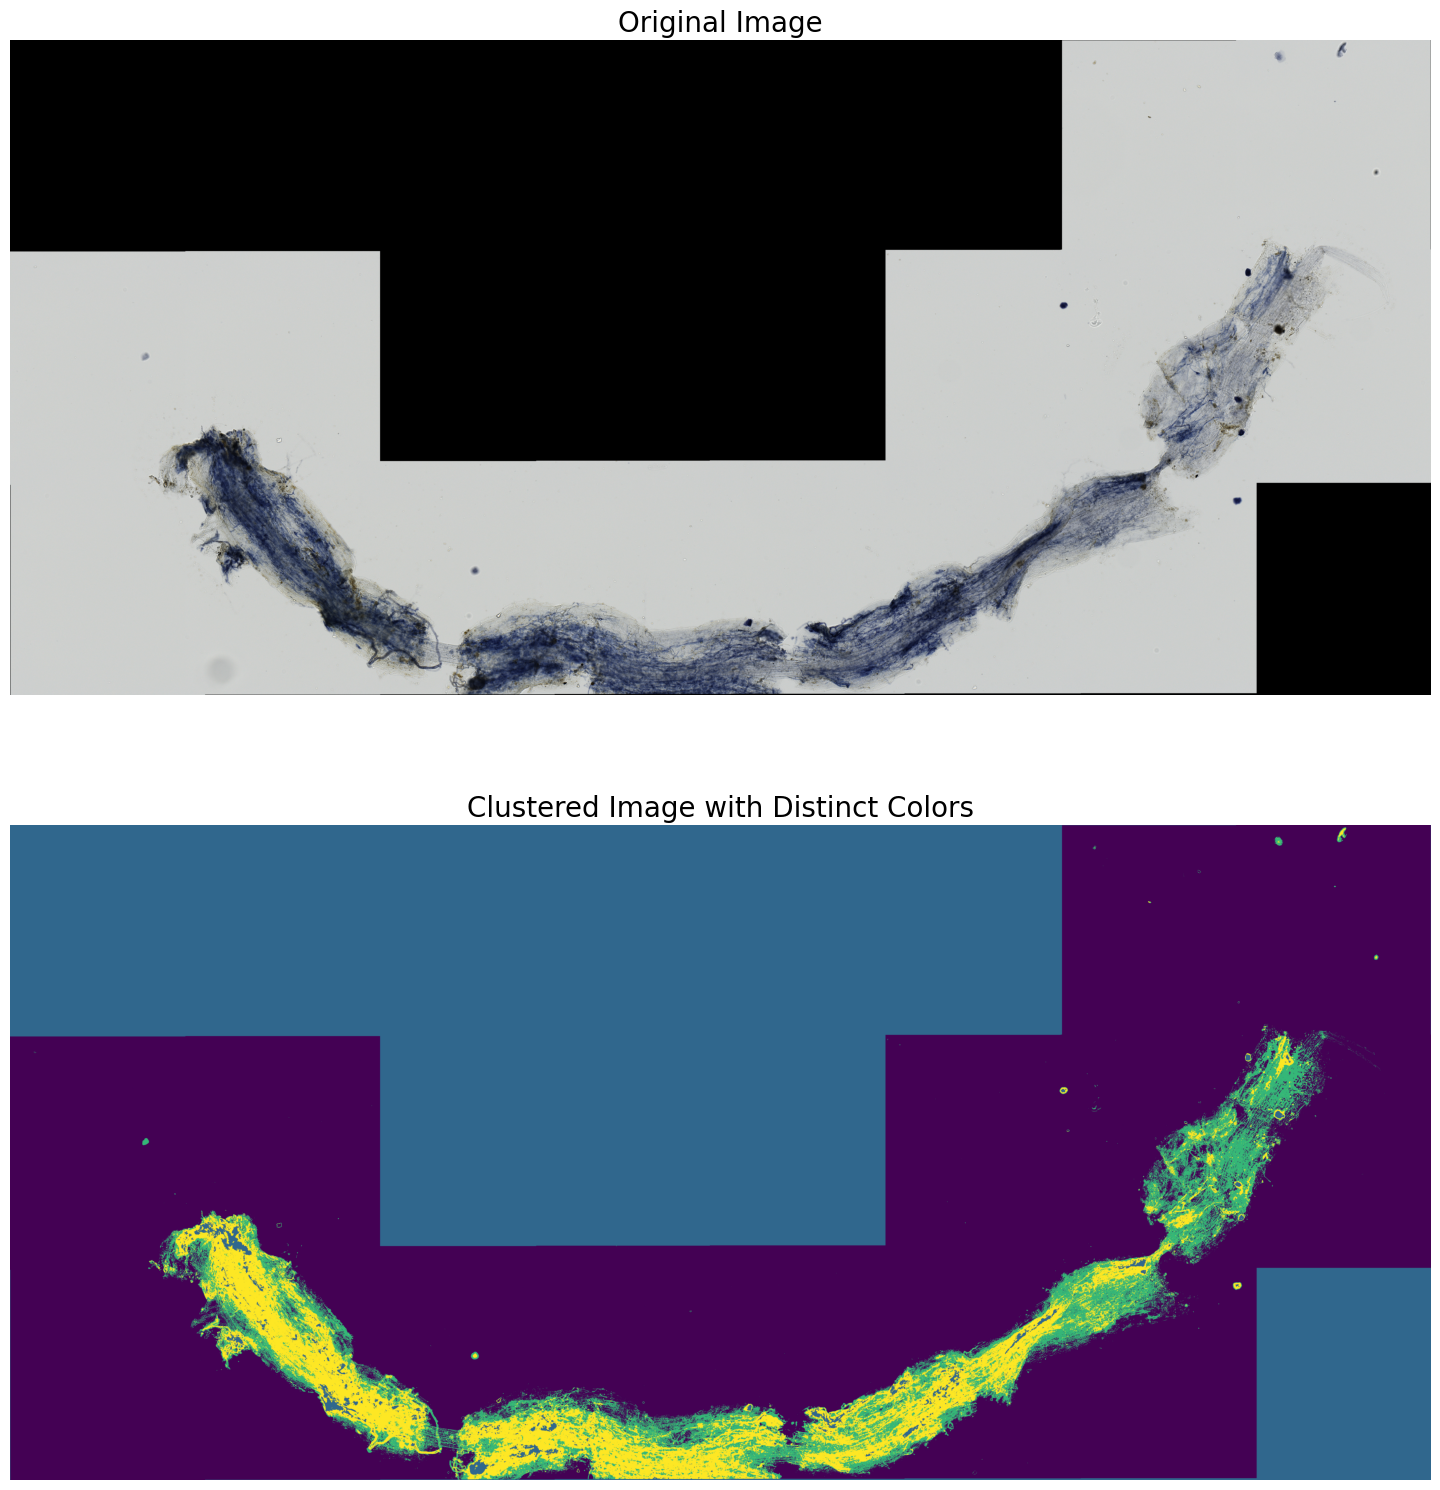

In [15]:

# Display the original, compressed, and clustered images with increased figure size
fig, ax = plt.subplots(2, 1, figsize=(48, 18))  # Increase the figsize here

# Original Image
ax[0].imshow(cv2.cvtColor(scene, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image', fontsize=20)  # You can also adjust the font size if needed
ax[0].axis('off')

# Clustered Image with Distinct Colors
ax[1].imshow(segmented_image)
ax[1].set_title('Clustered Image with Distinct Colors', fontsize=20)
ax[1].axis('off')

# Adjust subplots
plt.subplots_adjust(left=0.03, right=0.97, top=0.9, bottom=0.1)

plt.show()


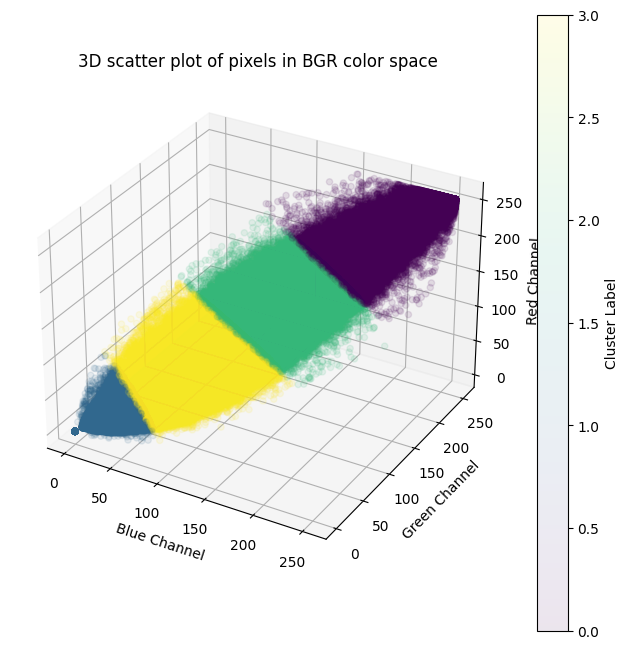

In [18]:
# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Color each point based on its cluster label
scatter = ax.scatter(pixels[:, 0], pixels[:, 1], pixels[:, 2], 
                     c=labels, cmap='viridis', alpha=0.1)

# Set labels according to RGB channels
ax.set_xlabel('Blue Channel')
ax.set_ylabel('Green Channel')
ax.set_zlabel('Red Channel')

# Add a color bar to understand which color relates to which cluster
#colorbar = plt.colorbar(scatter, ax=ax)
#colorbar.set_label('Cluster Label')

plt.title('3D scatter plot of pixels in BGR color space')
plt.show()

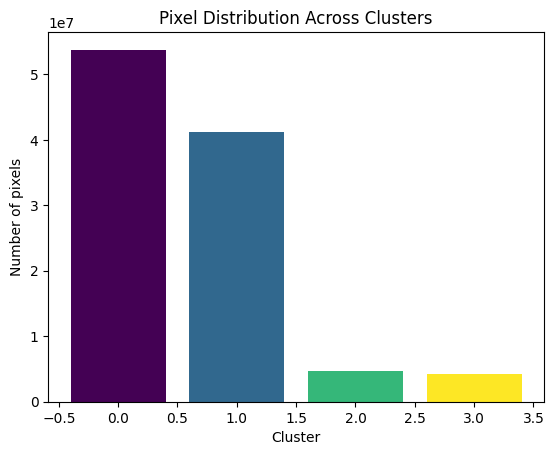

In [19]:
# Distribution of Pixels in Clusters
unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts, color=colors)
plt.title('Pixel Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of pixels')
plt.show()